In [1]:
import sys, os
sys.path.append(os.path.abspath("../src/"))

In [2]:
%reload_ext autoreload
%autoreload 2

import utils.dataset as dataset
import utils.evaluation as evaluation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from torch.utils.data import DataLoader, Subset
from torchvision import transforms

In [4]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
run = 'cnn'

In [8]:
# path = '../results/' + run + '/best_model.pth'
path = '../models/' + run + '.pth'
model = torch.load(path, map_location=device)

/Users/basile/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'models.cnn.Network' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [9]:
transform = transforms.Compose([
    transforms.Resize(60),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Predictions

In [10]:
data = dataset.KaggleDataset('../data/testset/', transform=transform)

In [12]:
dataloader = torch.utils.data.DataLoader(data, batch_size=10)
print('>> {} batches to evaluate'.format(len(dataloader)))

>> 500 batches to evaluate


In [ ]:
predictions = evaluation.predict(model, dataloader, device)

Predicting:  85%|#########################################4       | 423/500 [02:52<00:38,  2.01it/s]

In [ ]:
preds = pd.DataFrame(predictions, columns=['label'])
preds.index = preds.index.values + 1
preds.index.names = ['id']
preds['label'] = preds['label'].apply(lambda x: 'Cat' if x == 0 else 'Dog')

In [ ]:
preds.head()

In [ ]:
preds.to_csv('outputs/submission.csv')

# Comparison

In [9]:
data = dataset.KaggleDataset('../data/trainset/', transform=transform)
data = Subset(data, indices=list(range(500)))

In [10]:
dataloader = torch.utils.data.DataLoader(data, batch_size=10)
print('>> {} batches to evaluate'.format(len(dataloader)))

>> 50 batches to evaluate


In [11]:
outputs, labels = evaluation.compare(model, dataloader, device)

Predicting: 100%|###################################################| 50/50 [00:18<00:00,  2.70it/s]


In [35]:
wrong_class = np.array([output[1 - label] for output, label in zip(outputs, labels)])

In [36]:
wrong_class.max()

0.9998647

In [37]:
i_star = wrong_class.argmax()

Let's remove the transformations:

In [49]:
data.dataset.transform = None

In [50]:
sample_star = data[i_star]

In [51]:
outputs[i_star]

array([9.9986470e-01, 1.3523045e-04], dtype=float32)

In [52]:
sample_star['label']

1

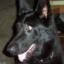

In [53]:
sample_star['image']

In [101]:
candidates = np.arange(len(wrong_class))[(.1 < wrong_class) & (wrong_class < .8)]

In [102]:
len(candidates)

9

In [103]:
wrong_class[candidates]

array([0.37240157, 0.6041632 , 0.1165431 , 0.12404354, 0.20101802,
       0.14863971, 0.19474433, 0.35215965, 0.61484206], dtype=float32)

In [104]:
i = -1

1


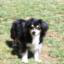

In [106]:
i += 1
print(i)
image = data[candidates[i]]['image']
image.save('outputs/50-50_{}.jpg'.format(i))
image

In [ ]:
image.save('outputs/images_{}.jpg'.format(i))

# Visualizing the convnet

In [181]:
data = dataset.KaggleDataset('../data/trainset/', transform=transform)
untransformed = dataset.KaggleDataset('../data/trainset/')

In [182]:
model

Network(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=115200, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

## Feature maps

Registering hooks in order to get the activation layers:

In [183]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [184]:
for layer in ['conv1', 'conv2', 'conv3', 'conv4']:
    model.conv1.register_forward_hook(get_activation(layer))

Select an image to visualize:

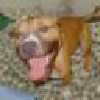

In [187]:
i = 10

image = data[i]['image']
image.unsqueeze_(0)

# Visualizing the untransformed version:
untransformed[i]['image'].resize((100, 100))

Getting the activations

In [188]:
output = model(image)

act = {}

for layer in ['conv1', 'conv2', 'conv3', 'conv4']:
    act[layer] = activation[layer].squeeze()

We can now visualize the feature maps:

In [195]:
layer = 'conv4'

In [196]:
i = -1

Layer: conv4
Feature map #32


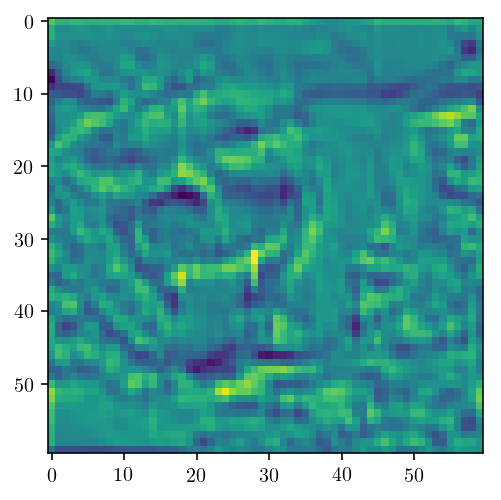

In [228]:
i += 1

print('Layer: {}'.format(layer))
print('Feature map #{}'.format(i + 1))

plt.imshow(act[layer][i])
plt.show()

## Kernels

For example, the first convolutional layer:

In [229]:
kernels = model.conv1.weight.detach()

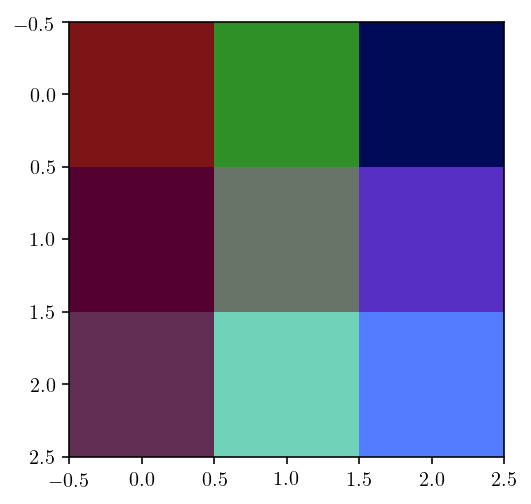

In [230]:
plt.imshow(normalize_output(kernels[1]), cmap='gray')

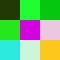

In [231]:
i += 1
transforms.functional.to_pil_image(kernels[i]).resize((60, 60))